# Measures of overall cost and danger
We want to capture the fact that more intense storms (Fujita scale 5 tornadoes, magnitude 8 earthquakes) are worse than other events, and that deaths are worse than injuries and property damages.  While we provide all these data separately, this is our opportunity to combine them into a custom metric that illustrates just how dangerous it is to live somewhere.  We account for the different magnitudes of earthquakes and tornadoes, for which we have such data, but don't distinguish between the severity of other events.

We recognize that the weights of these factors are chosen arbitrarily, but we think this still conveys more information than not combining these parameters at all, or than giving all sorts of natural disasters equal weight.

In [221]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import numpy as np

# Custom function for displaying the shape and head of a dataframe
def display(df, n=5):
    print(df.shape)
    return df.head(n)

# Get counties

In [222]:
# Import a shape file with all the counties in the US.
# Note how it doesn't include all the same territories as the 
# quake contour map.
counties = geopandas.read_file('../data_input/1_USCounties/')

# Turn state codes from strings to integers
for col in ['STATE_FIPS', 'CNTY_FIPS', 'FIPS']:
    counties[col] = counties[col].astype(int)
    
display(counties)

(3141, 6)


,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,geometry
0,Lake of the Woods,Minnesota,27,77,27077,"POLYGON ((-95.34283127277658 48.546679319076, ..."
1,Ferry,Washington,53,19,53019,POLYGON ((-118.8516288013387 47.94956368481996...
2,Stevens,Washington,53,65,53065,"POLYGON ((-117.438831576286 48.04411548512263,..."
3,Okanogan,Washington,53,47,53047,"POLYGON ((-118.972093862835 47.93915200536639,..."
4,Pend Oreille,Washington,53,51,53051,POLYGON ((-117.4385804303028 48.99991850672649...


# Get disaster data

## Quakes
I choose to aggregate quakes based on the energy they release.  This way we prevent little earthquakes from dominating the conversation, when it's the big ones that really matter.  [This website](https://www.bgs.ac.uk/discoveringGeology/hazards/earthquakes/magnitudeScaleCalculations.html) says how to calculate quake energy from magnitude.

In [223]:
quakes = geopandas.read_file('../data_output/5__USGS_quakes/quakes1.geojson')
display(quakes)

(2547, 4)


,FIPS,year,magnitude,geometry
0,6029,1996,5.17,POINT (-117.646 35.761)
1,6071,1996,4.16,POINT (-117.62 35.755)
2,6071,1996,4.36,POINT (-117.636 35.779)
3,6071,1996,4.24,POINT (-117.632 35.799)
4,6071,1996,4.19,POINT (-116.943 34.994)


In [440]:
# Calculate the total energy released by each earthquake (in Joules).
quakes['energy'] = 10**(1.5*quakes['magnitude'])

# Create a dataframe that aggregates all earthquakes by county, 
# summing up their magnitude
quakes2 = quakes[['FIPS', 'energy']].groupby('FIPS').sum()\
                                .rename(columns={'energy':'quake_energy'})

display(quakes2)

(191, 1)


,quake_energy
FIPS,
1049,7.943282e+06
1053,1.584893e+07
1063,2.818383e+06
2013,1.597265e+08
2016,1.252253e+09


## Tornadoes
Our NOAA data classifies tornadoes according to the old Fujita scale before 1997, and according to the Enhanced Fujita scale since then.  Both scales are a measure of damages, but are not as readily quantifiable as earthquakes.  I choose to treat them as if they were all on a logarithmic scale.  I selected my parameters such that a category 5 tornado is equivalent to 316 category-0 tornadoes, which matches my intuition for how different in importance they really are.  The relative weights are:

```
cat - weight
F0  - 1
F1  - 3.16
F2  - 10
F3  - 31.6
F4  - 100
F5  - 316
```

In [225]:
tornadoes = geopandas.read_file('../data_output/5__NOAA/tornadoes.geojson')
display(tornadoes)

(30898, 3)


,year,intensity,geometry
0,1996,1,POINT (-89.87 36.18)
1,1996,1,POINT (-90.97 34.55)
2,1996,1,POINT (-92.31999999999999 30.57)
3,1996,0,POINT (-86.97 40.5)
4,1996,2,POINT (-96.15000000000001 33.72)


In [226]:
# Calculate an exponential measure of intensity
tornadoes['exp_intensity'] = 10**(0.5*tornadoes['intensity'])

# Mark all tornadoes with the county where they happened
tornadoes2 = geopandas.sjoin(tornadoes, counties, how='left', op='within')

# Single out only relevant columns, and group by county 
# (again, adding up magnitudes)
tornadoes2 = tornadoes2[['exp_intensity','FIPS']]\
                    .groupby('FIPS').sum()\
                    .rename(columns={'exp_intensity':'tornado_intensity'})

display(tornadoes2)

(2869, 1)


,tornado_intensity
FIPS,
1001,123.706052
1003,107.920998
1005,45.135944
1007,31.298221
1009,273.381497


## Damages

In [227]:
damages = pd.read_csv('../data_output/5__NOAA/damages_by_county.csv')
display(damages)

(3141, 4)


,FIPS,damage,deaths,injuries
0,1001,26788100.0,7.0,96.0
1,1003,54686000.0,29.0,57.0
2,1005,2594000.0,0.0,17.0
3,1007,16973750.0,1.0,20.0
4,1009,33177500.0,1.0,59.0


## Other storms
I'm aggregating all of our best sources for storms here.  I'll use the NOAA data for most types, but FEMA data for hurricanes.  I'll also create columns that tell us how many storms of a given type that county had, as a percentage of the mean national value. 

In [309]:
# Import FEMA data
fema = geopandas.read_file('../data_output/4__FEMA_county/')

# Aggregate by FIPS, keep only useful columns
fema = fema.sort_values('FIPS').set_index(['FIPS'])[['Hurricane']]

# Cast hurricanes as int
fema['Hurricane'] = fema['Hurricane'].astype(int)
    
display(fema)

(3141, 1)


,Hurricane
FIPS,
1001,8
1003,20
1005,8
1007,7
1009,4


In [313]:
# Import NOAA extreme weather events
noaa = pd.read_csv('../data_output/5__NOAA/noaa_2.csv')\

# Aggregate by FIPS, keep only useful columns
noaa = noaa.groupby('FIPS').sum()[['Winter Weather','Storm','Flood','Fire','Heat',
                 'Drought']]

# Rename Winter Weather to Winter
noaa = noaa.rename(columns={'Winter Weather':'Winter'})

display(noaa)

(3141, 6)


,Winter,Storm,Flood,Fire,Heat,Drought
FIPS,,,,,,
1001,17,225,28,0,5,36
1003,5,322,100,0,0,0
1005,7,120,7,0,8,49
1007,18,131,17,0,5,34
1009,33,312,37,0,4,29


In [353]:
# Merge NOAA and FEMA data
storms = pd.merge(noaa, fema, how='left', on='FIPS')

# Create columns that show a county's storm count as a 
# percentage of the national median.  

cols = storms.columns

# Add columns for the median national value of each disaster type.
# Since the national median for Fire is 0, in that case I used 1 instead
# to prevent division by zero errors
for col in cols:
    if storms[col].median() > 0:
        storms['median_' + col] = storms[col].median()
    else:
        storms['median_' + col] = 1
        
# Add columns for disaster counts normalized to that median
for col in cols:
    storms['pct_' + col] = storms[col] / storms['median_' + col] * 100    
        
# Add county geometries
storms['geometry'] = counties.sort_values('FIPS').set_index('FIPS')['geometry']

# Turn into geopandas object
storms = geopandas.GeoDataFrame(storms)

display(storms)

(3141, 22)


,Winter,Storm,Flood,Fire,Heat,Drought,Hurricane,median_Winter,median_Storm,median_Flood,...,median_Drought,median_Hurricane,pct_Winter,pct_Storm,pct_Flood,pct_Fire,pct_Heat,pct_Drought,pct_Hurricane,geometry
FIPS,,,,,,,,,,,,,,,,,,,,,
1001,17,225,28,0,5,36,8,60.0,196.0,30.0,...,9.0,1.0,28.333333,114.795918,93.333333,0.0,166.666667,400.000000,800.0,POLYGON ((-86.82066986329349 32.34730960076057...
1003,5,322,100,0,0,0,20,60.0,196.0,30.0,...,9.0,1.0,8.333333,164.285714,333.333333,0.0,0.000000,0.000000,2000.0,POLYGON ((-87.97308978075395 31.16482251520438...
1005,7,120,7,0,8,49,8,60.0,196.0,30.0,...,9.0,1.0,11.666667,61.224490,23.333333,0.0,266.666667,544.444444,800.0,POLYGON ((-85.74337279655801 31.62624052460075...
1007,18,131,17,0,5,34,7,60.0,196.0,30.0,...,9.0,1.0,30.000000,66.836735,56.666667,0.0,166.666667,377.777778,700.0,POLYGON ((-87.41985563876936 33.01177307648309...
1009,33,312,37,0,4,29,4,60.0,196.0,30.0,...,9.0,1.0,55.000000,159.183673,123.333333,0.0,133.333333,322.222222,400.0,POLYGON ((-86.96799449037186 33.86045466926403...


In [354]:
# Export as geoJSON file
storms.to_file("../data_output/6__danger/storms.geojson", driver='GeoJSON')

In [355]:
# Remove geometry and export as CSV
storms_plain = storms.drop(columns='geometry')
storms_plain.to_csv("../data_output/6__danger/storms.csv")

# Create aggregate measures of danger
I'll account separately for events (storms, tornadoes and quakes) and overall costs (property damage, deaths, and injuries).  

## Combine everything into a single dataframe

In [408]:
# Merge quakes2 with counties to create a new dataframe called 'danger'.
danger = pd.merge(counties, quakes2, how='left', on='FIPS')\
                                                .fillna(0)
# Merge tornadoes2 into danger
danger = pd.merge(danger, tornadoes2, how='left', on='FIPS')\
                                                .fillna(0)
# Merge damages into danger
danger = pd.merge(danger, damages, how='left', on='FIPS')

# Merge storms into danger
danger = pd.merge(danger, storms[['Winter', 'Storm', 
        'Flood', 'Fire', 'Heat', 'Drought', 'Hurricane']],
                  how='left', on='FIPS')

# Drop useless columns
danger = danger.drop(columns=['NAME', 'STATE_NAME', 'STATE_FIPS', 'CNTY_FIPS'])

# Set FIPS as the index.
danger = danger.sort_values('FIPS').set_index('FIPS')

In [409]:
display(danger)

(3141, 13)


,geometry,quake_energy,tornado_intensity,damage,deaths,injuries,Winter,Storm,Flood,Fire,Heat,Drought,Hurricane
FIPS,,,,,,,,,,,,,
1001,POLYGON ((-86.82066986329349 32.34730960076057...,0.0,123.706052,26788100.0,7.0,96.0,17,225,28,0,5,36,8
1003,POLYGON ((-87.97308978075395 31.16482251520438...,0.0,107.920998,54686000.0,29.0,57.0,5,322,100,0,0,0,20
1005,POLYGON ((-85.74337279655801 31.62624052460075...,0.0,45.135944,2594000.0,0.0,17.0,7,120,7,0,8,49,8
1007,POLYGON ((-87.41985563876936 33.01177307648309...,0.0,31.298221,16973750.0,1.0,20.0,18,131,17,0,5,34,7
1009,POLYGON ((-86.96799449037186 33.86045466926403...,0.0,273.381497,33177500.0,1.0,59.0,33,312,37,0,4,29,4


## Costs
I'll turn everything into dollars, including deaths and injuries.  I'll turn deaths into dollars using the [statistical value of a human life in the USA](https://en.wikipedia.org/wiki/Value_of_life#United_States)
, which I approximate as 9 million dollars.  I'll turn injuries into dollars by assuming that an injury costs on average 1 year of quality-adjusted life, which is commonly set at 50,000 dollars.  I'll then create a logarithmic version of this cost scale (that will be easier to visualize on a map) and bin it into six sensible bins.

In [410]:
# Create unified measure of cost
danger['cost'] = danger.damage + danger.deaths*9000000 + danger.injuries*50000

# Figure out cost as a percentage of national mean.
usa_median = danger.cost.median()
danger['cost_percent_of_median'] = danger['cost'] / usa_median *100

# Create logarithmic measure of cost and normalize it so that it 
# has a mean of 0 and a standard deviation of 1
from sklearn.preprocessing import robust_scale
danger['cost_norm'] = robust_scale(np.log10(danger['cost']+1))

# Bin cost into 1, 2, or >2 standard deviations away from the mean
danger['cost_bins'] = pd.cut(danger['cost_norm'], bins=[-20,-2,-1,0,1,2,20], 
                               include_lowest=True, retbins=False, labels=False)

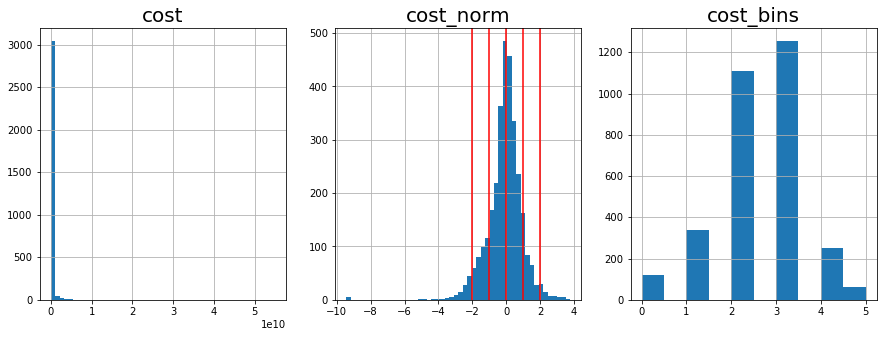

In [472]:
# Compare: Original, normalized, and binned data
fig, (ax, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
var1 = 'cost'
var2 = 'cost_norm'
var3 = 'cost_bins'

danger[var1].hist(ax=ax, bins=50);
ax.set_title(var1, fontsize=20)

danger[var2].hist(ax=ax2, bins=50);
ax2.axvline(-2, color='r')
ax2.axvline(-1, color='r')
ax2.axvline(0, color='r')
ax2.axvline(1, color='r')
ax2.axvline(2, color='r')
ax2.set_title(var2, fontsize=20)

danger[var3].hist(ax=ax3);
ax3.set_title(var3, fontsize=20)

plt.show()

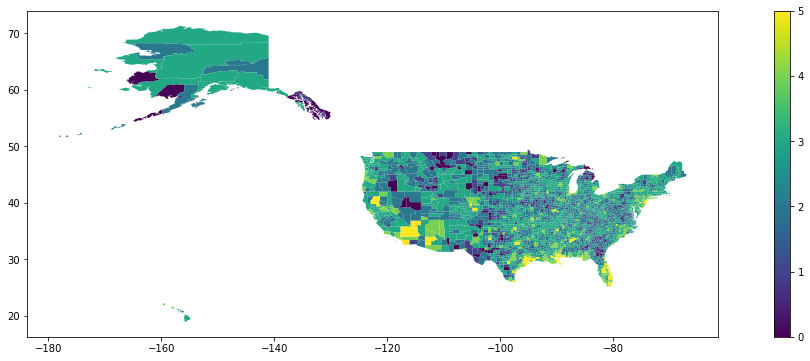

In [473]:
danger.plot(column='cost_bins', figsize=(20,6), legend=True);

## Disaster counts
I want to create a neat bell curve of disaster frequency, based on combining various measures of disaster frequencies, some of them logarithmic, and all of them normalized and weighted so that more powerful disasters (data only available for quakes and tornadoes) have greater weight.

### Storms

In [416]:
# Aggregate together all the events that don't have explicit intensity measures.
# I give hurricanes 100x more weight as the other events because they seem 
# more important and also because these hurricanes come from the FEMA dataset,
# and only made it to the data when they were declared federal disasters.
danger['storms'] = danger['Winter']\
                    + danger['Storm']\
                    + danger['Flood']\
                    + danger['Fire']\
                    + danger['Heat']\
                    + danger['Drought']\
                    + danger['Hurricane'] * 100

# These disaster events are log-normally distributed, so let's take the 
# log10 and normalize the result
danger['storms_norm'] = robust_scale(np.log10(danger['storms']+1))

# Bin into 1, 2, or >2 standard deviations away from the mean
danger['storms_bins'] = pd.cut(danger['storms_norm'], bins=[-20,-2,-1,0,1,2,20], 
                               include_lowest=True, retbins=False, labels=False)

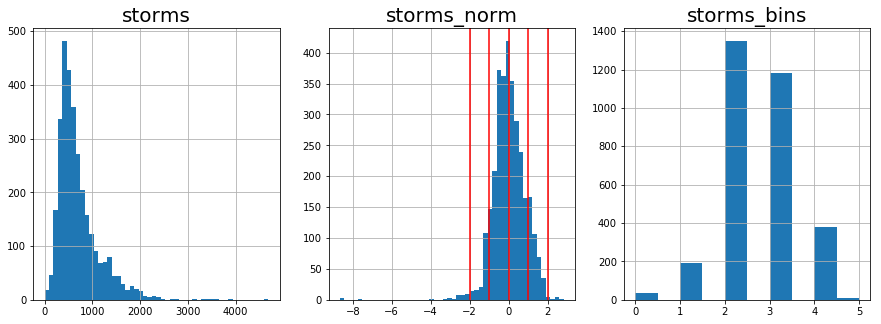

In [417]:
# Compare: Original, normalized, and binned data
fig, (ax, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
var1 = 'storms'
var2 = 'storms_norm'
var3 = 'storms_bins'

danger[var1].hist(ax=ax, bins=50);
ax.set_title(var1, fontsize=20)

danger[var2].hist(ax=ax2, bins=50);
ax2.axvline(-2, color='r')
ax2.axvline(-1, color='r')
ax2.axvline(0, color='r')
ax2.axvline(1, color='r')
ax2.axvline(2, color='r')
ax2.set_title(var2, fontsize=20)

danger[var3].hist(ax=ax3);
ax3.set_title(var3, fontsize=20)

plt.show()

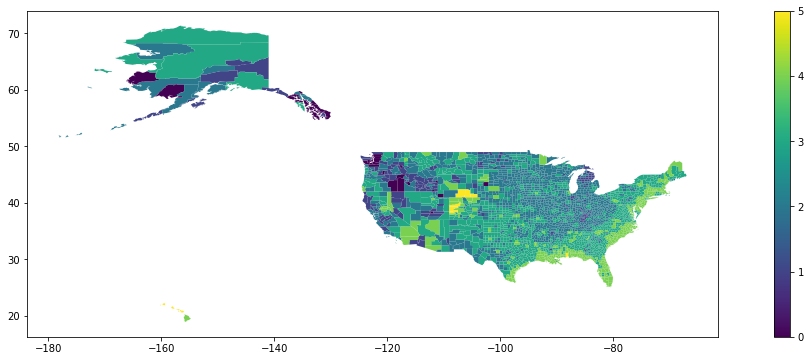

In [418]:
danger.plot(column='storms_bins', figsize=(20,6), legend=True);

### Quakes
Earthquakes are tricky, because only 191 counties (out of 3141) had any quakes registered, and their distribution of energy is super skewed.  I will carry out my normalization on just the dataframe of the counties that did have quakes, and then merge that back into the overall danger dataframe.

In [444]:
# Rename into the style we've been using
display(quakes2, n=2)

(191, 1)


,quake_energy
FIPS,
1049,7.943282e+06
1053,1.584893e+07


In [445]:
# Rename into the style we've been using
quakes2 = quakes2.rename(columns={'quake_energy':'quakes'})

# These disaster events are log-normally distributed, so let's take the 
# log10 and normalize the result
quakes2['quakes_norm'] = robust_scale(np.log10(quakes2['quakes']+1))

# Bin into 1, 2, or >2 standard deviations away from the mean
quakes2['quakes_bins'] = pd.cut(quakes2['quakes_norm'], bins=[-20,-2,-1,0,1,2,20], 
                               include_lowest=True, retbins=False, labels=False)

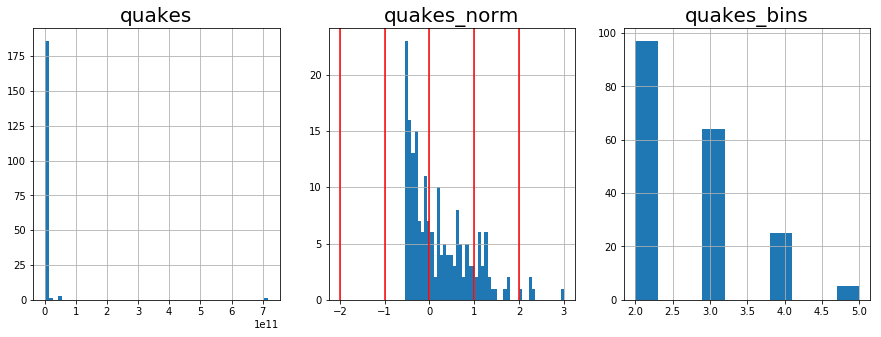

In [446]:
# Compare: Original, normalized, and binned data
fig, (ax, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
var1 = 'quakes'
var2 = 'quakes_norm'
var3 = 'quakes_bins'

quakes2[var1].hist(ax=ax, bins=50);
ax.set_title(var1, fontsize=20)

quakes2[var2].hist(ax=ax2, bins=50);
ax2.axvline(-2, color='r')
ax2.axvline(-1, color='r')
ax2.axvline(0, color='r')
ax2.axvline(1, color='r')
ax2.axvline(2, color='r')
ax2.set_title(var2, fontsize=20)

quakes2[var3].hist(ax=ax3);
ax3.set_title(var3, fontsize=20)

plt.show()

In [447]:
# Merge back into danger
danger = pd.merge(danger, quakes2, how='left', on='FIPS')\
                                                .fillna(0)
display(danger, n=1)

(3141, 22)


,geometry,tornado_intensity,damage,deaths,injuries,Winter,Storm,Flood,Fire,Heat,...,cost,cost_percent_of_median,cost_norm,cost_bins,storms,storms_norm,storms_bins,quakes,quakes_norm,quakes_bins
FIPS,,,,,,,,,,,,,,,,,,,,,
1001,POLYGON ((-86.82066986329349 32.34730960076057...,123.706052,26788100.0,7.0,96.0,17,225,28,0,5,...,94588100.0,200.260626,0.371009,3,1111,0.875725,3,0.0,0.0,0.0


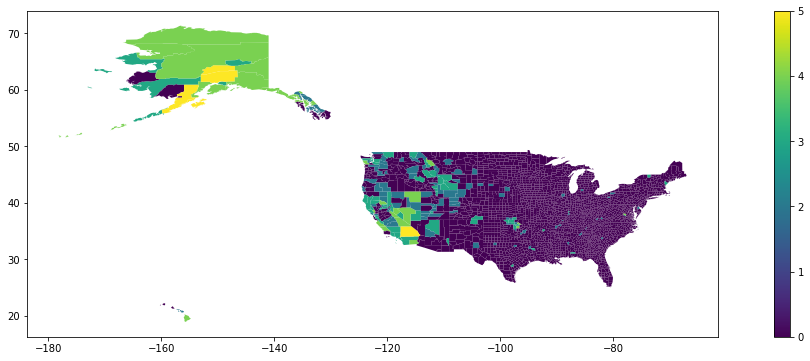

In [449]:
danger.plot(column='quakes_bins', figsize=(20,6), legend=True);

### Tornadoes

In [451]:
# Rename tornadoes in the style we've been using
danger['tornadoes'] = danger['tornado_intensity']
danger = danger.drop(columns='tornado_intensity')

# These disaster events are log-normally distributed, so let's take the 
# log10 and normalize the result
danger['tornadoes_norm'] = robust_scale(np.log10(danger['tornadoes']+1))

# Bin into 1, 2, or >2 standard deviations away from the mean
danger['tornadoes_bins'] = pd.cut(danger['tornadoes_norm'], bins=[-20,-2,-1,0,1,2,20], 
                               include_lowest=True, retbins=False, labels=False)

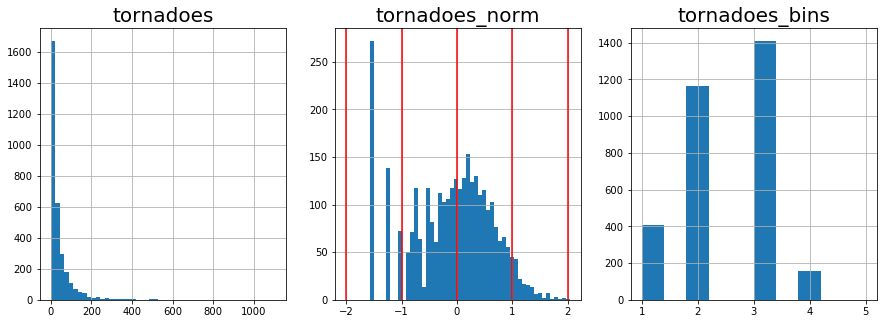

In [474]:
# Compare: Original, normalized, and binned data
fig, (ax, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
var1 = 'tornadoes'
var2 = 'tornadoes_norm'
var3 = 'tornadoes_bins'

danger[var1].hist(ax=ax, bins=50);
ax.set_title(var1, fontsize=20)

danger[var2].hist(ax=ax2, bins=50);
ax2.axvline(-2, color='r')
ax2.axvline(-1, color='r')
ax2.axvline(0, color='r')
ax2.axvline(1, color='r')
ax2.axvline(2, color='r')
ax2.set_title(var2, fontsize=20)

danger[var3].hist(ax=ax3);
ax3.set_title(var3, fontsize=20)

plt.show()

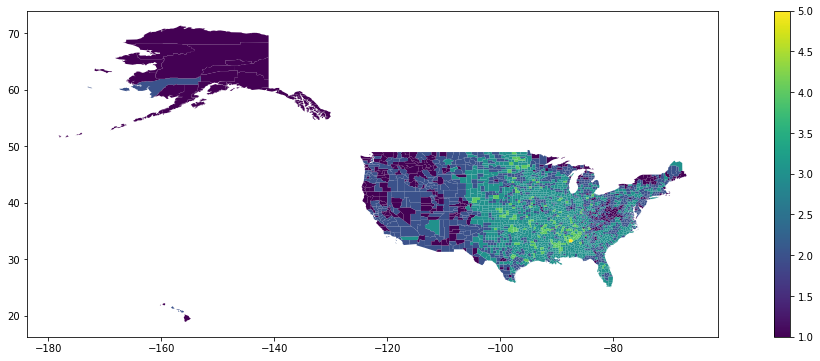

In [455]:
danger.plot(column='tornadoes_bins', figsize=(20,6), legend=True);

### All events

In [458]:
# Aggregate the normalized versions of storms, quakes, and tornadoes
danger['danger_norm'] = danger['storms_norm'] + danger['quakes_norm'] + danger['tornadoes_norm']

# Bin into 1, 2, or >2 standard deviations away from the mean
danger['danger_bins'] = pd.cut(danger['danger_norm'], bins=[-20,-2,-1,0,1,2,20], 
                               include_lowest=True, retbins=False, labels=False)

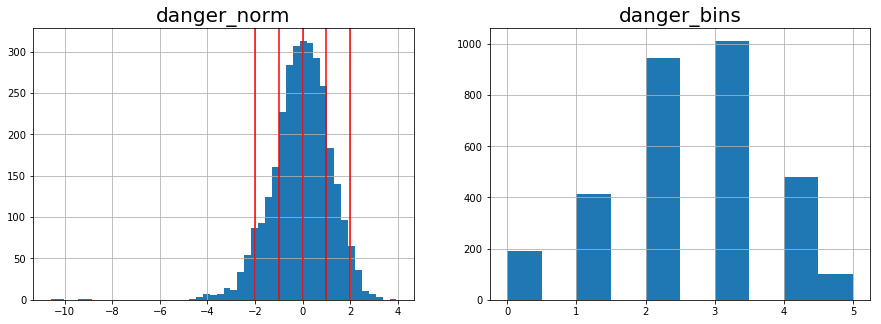

In [463]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
var2 = 'danger_norm'
var3 = 'danger_bins'

danger[var2].hist(ax=ax1, bins=50);
ax1.axvline(-2, color='r')
ax1.axvline(-1, color='r')
ax1.axvline(0, color='r')
ax1.axvline(1, color='r')
ax1.axvline(2, color='r')
ax1.set_title(var2, fontsize=20)

danger[var3].hist(ax=ax2);
ax2.set_title(var3, fontsize=20)

plt.show()

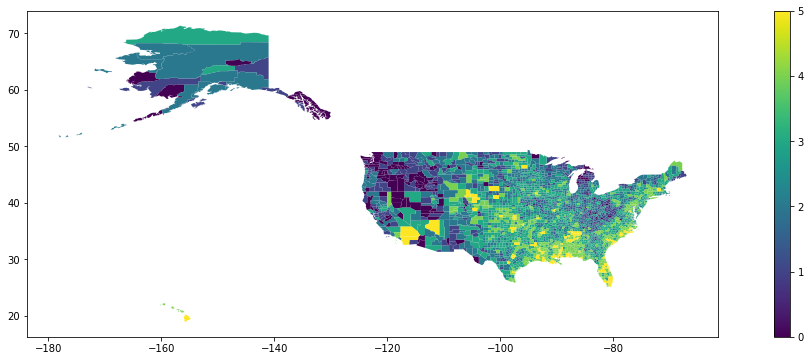

In [464]:
danger.plot(column='danger_bins', figsize=(20,6), legend=True);

# Export

In [467]:
danger2 = danger[['geometry', 'damage', 'deaths', 'injuries', 'cost',
       'cost_percent_of_median', 'cost_bins','danger_bins']].copy()

In [468]:
display(danger2)

(3141, 8)


,geometry,damage,deaths,injuries,cost,cost_percent_of_median,cost_bins,danger_bins
FIPS,,,,,,,,
1001,POLYGON ((-86.82066986329349 32.34730960076057...,26788100.0,7.0,96.0,94588100.0,200.260626,3,4
1003,POLYGON ((-87.97308978075395 31.16482251520438...,54686000.0,29.0,57.0,318536000.0,674.400042,4,5
1005,POLYGON ((-85.74337279655801 31.62624052460075...,2594000.0,0.0,17.0,3444000.0,7.291589,1,4
1007,POLYGON ((-87.41985563876936 33.01177307648309...,16973750.0,1.0,20.0,26973750.0,57.108453,2,3
1009,POLYGON ((-86.96799449037186 33.86045466926403...,33177500.0,1.0,59.0,45127500.0,95.543323,2,4


In [470]:
# Export as geoJSON file
danger2.to_file("../data_output/6__danger/danger.geojson", driver='GeoJSON')

In [471]:
# Remove geometry and export as CSV
danger3 = danger2.drop(columns='geometry')
danger3.to_csv("../data_output/6__danger/danger.csv")